#### <h1 align=center><font size = 5>Capstone Project -18 : Crop Recommendation System</font></h1>
<h2 align=center><font size = 5>AIML Certification Programme</font></h2>

## Team <br>
1. Anuj Alex (2024AIML009)​
2. Gurbachan Singh Kalwan (2024AIML004)​
3. Krishna Murthy P (2024AIML078)​
4. Sidharth Gupta (2024AIML017)
5. Sree Rama Kumar Yeddanapudi (2024AILML008)​

Mentor: Prof. Aniruddha Dasgupta

In [302]:
import numpy as np # linear algebra
import pandas as pd

import matplotlib.pylab as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, MinMaxScaler

from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, top_k_accuracy_score

from rapidfuzz import process, fuzz

import os, re, warnings, joblib

from catboost import CatBoostClassifier, Pool
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
warnings.filterwarnings("ignore")

In [303]:
# ===================== CONFIG =====================
DATA_PATH = "../data/AP_data.csv"
DIST_PATH = "../data/AP_district_level_master.csv"
USE_TOP_N_CLASSES = True
TOP_N = 12
TEST_SIZE = 0.25
RANDOM_STATE = 42

In [304]:
CB_PARAMS = dict(
    iterations=1200,
    depth=8,
    learning_rate=0.05,
    loss_function="MultiClass",
    eval_metric="Accuracy",
    l2_leaf_reg=3,
    bootstrap_type="Bernoulli",
    subsample=0.8,
    random_seed=RANDOM_STATE,
    auto_class_weights="Balanced",
    verbose=False
)

In [305]:
MODEL_OUT_CAT = "serving_catboost_topN.pkl"
MODEL_OUT_VOTE = "soft_voting_model.pkl"
REPORT_OUT = "training_report_topN_voting.txt"
COMPARE_CSV = "model_comparison_top3_voting.csv"

### 1. Loading and Reading Dataset

In [306]:
df = pd.read_csv(DATA_PATH)
df.rename(columns={"Extent\n(AC)":"Farm_Acres","Crop before":"Crop_Sown"},inplace=True)
df['District'] = df['District'].replace({
    "Anantapur": "Ananthapur",
    "S.P.S.Nellore": "Nellore",
    "S.P.S. Nellore": "Nellore",
    "Kadapa YSR": "Kadapa"
})
df.head()

,Sl no,Date,Farmer No,Macro/ Micro nutrient,Farmer Name,District,Mandal,Village,Latitude,Longitude,...,Avail-Mg,Avail-S,Avail-Zn,Avail-B,Avail-Fe,Avail-Cu,Avail-Mn,Time,Season,Recommended Sowing Time
0,1.0,1/1/2015,1910,RK2276,P.Krishna Naik,Ananthapur,Penukonda,Gonipeta,14.08,77.69,...,101.0,5.16,0.30,0.17,8.89,0.51,15.24,1/1/2015,Kharif & Rabi,Kharif: June - July & Rabi: October - November
1,2.0,1/1/2015,1911,RK2277,Kallu Thippe Naik,Ananthapur,Penukonda,Gonipeta,14.09,77.69,...,261.0,9.91,0.36,0.57,3.24,0.44,6.90,1/1/2015,Kharif & Rabi,Kharif: June - July & Rabi: October - November
2,3.0,1/1/2015,1912,RK2278,P.Duble Bai,Ananthapur,Penukonda,Gonipeta,14.09,77.69,...,48.0,3.77,0.37,0.19,5.54,0.42,8.34,1/1/2015,Kharif & Rabi,Kharif: June - July & Rabi: October - November
3,4.0,1/1/2015,1913,RK2279,H.Marekka (Kamma),Ananthapur,Penukonda,Gonipeta,14.10,77.70,...,52.0,4.14,0.23,0.21,1.79,0.67,4.17,1/1/2015,Rabi,September - October
4,5.0,1/1/2015,1914,RK2280,M.Alevelamma,Ananthapur,Penukonda,Gonipeta,14.09,77.69,...,84.0,1.45,0.36,0.22,22.26,0.45,9.20,1/1/2015,Rabi,September - October


In [307]:
dist_master = pd.read_csv(DIST_PATH)
dist_master.head()

,State,District,Soil_Percent,N_per_Ha,P_per_Ha,K_per_Ha,Kharif_rain,Rabi_rain,Zaid_rain,Area,Rank,Stand_Soil,Stand_Crop
0,Andhra Pradesh,Ananthapur,100,27.71,17.96,6.99,272,148,77,594.740,1.0,Sandy,['Groundnut']
1,Andhra Pradesh,Ananthapur,100,27.71,17.96,6.99,272,148,77,586.860,2.0,Sandy,['Other']
2,Andhra Pradesh,Ananthapur,100,27.71,17.96,6.99,272,148,77,51.825,3.0,Sandy,['Rice']
3,Andhra Pradesh,Ananthapur,100,27.71,17.96,6.99,272,148,77,43.055,4.0,Sandy,['Other']
4,Andhra Pradesh,Ananthapur,100,27.71,17.96,6.99,272,148,77,24.800,5.0,Sandy,['Pigeonpea']


### 1.1 Merge datasets

In [308]:
# Merge the DataFrames using left_on and right_on
rain_df= dist_master[["District","Kharif_rain",	"Rabi_rain",	"Zaid_rain"]].drop_duplicates()
# print(rain_df.head())
merged_df = pd.merge(df,rain_df, left_on='District', right_on='District',how='left')

### 1.2 Remove unnecessary columns

In [309]:
merged_df.drop(columns=["Sl no", "Date", "Farmer No", "Macro/ Micro nutrient", "Farmer Name", "Fathers Name", "Time"
                        , "Recommended Sowing Time", "Season", "Farm_Acres", "Survey No.","Latitude","Longitude"], inplace=True)

In [310]:
orig_df = df
df = merged_df

### 1.3 Check basic data statistics (shape, info, describe)

In [311]:
df.shape

(4816, 21)

In [312]:
df.describe()

,pH,EC,Avail-P,Exch-K,Avail-Ca,Avail-Mg,Avail-Zn,Avail-Fe,Avail-Cu,Avail-Mn,Kharif_rain,Rabi_rain,Zaid_rain
count,4815.000000,4815.000000,4815.000000,4815.000000,4815.000000,4815.000000,4815.000000,4815.000000,4815.000000,4815.000000,4815.000000,4815.000000,4815.000000
mean,7.477844,0.489531,16.704285,159.676012,2416.086604,522.878920,1.111973,28.349657,2.533325,18.805155,503.790447,311.759917,74.812461
std,1.052134,1.045581,18.810818,135.616280,2155.234533,473.764527,1.396243,38.578050,3.061383,18.965475,169.263499,151.074131,19.353745
min,4.150000,0.010000,0.450000,12.000000,20.000000,2.000000,0.030000,0.040000,0.030000,0.010000,272.000000,125.000000,49.000000
25%,6.740000,0.110000,5.160000,82.000000,839.000000,184.000000,0.410000,5.780000,0.930000,8.100000,404.000000,235.000000,55.000000
50%,7.810000,0.220000,10.930000,129.000000,1652.000000,374.000000,0.700000,12.210000,1.460000,12.960000,455.000000,270.000000,70.000000
75%,8.270000,0.510000,21.410000,196.000000,3150.500000,715.500000,1.250000,33.980000,2.600000,22.125000,699.000000,375.000000,94.000000
max,9.890000,27.500000,361.940000,2409.000000,13304.000000,5363.000000,23.920000,354.700000,20.180000,256.880000,806.000000,710.000000,109.000000


In [313]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4816 entries, 0 to 4815
Data columns (total 21 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   District     4815 non-null   object 
 1   Mandal       4815 non-null   object 
 2   Village      4815 non-null   object 
 3   Soil type    4749 non-null   object 
 4   Crop_Sown    4595 non-null   object 
 5   pH           4815 non-null   float64
 6   EC           4815 non-null   float64
 7   OC           4815 non-null   object 
 8   Avail-P      4815 non-null   float64
 9   Exch-K       4815 non-null   float64
 10  Avail-Ca     4815 non-null   float64
 11  Avail-Mg     4815 non-null   float64
 12  Avail-S      4815 non-null   object 
 13  Avail-Zn     4815 non-null   float64
 14  Avail-B      4815 non-null   object 
 15  Avail-Fe     4815 non-null   float64
 16  Avail-Cu     4815 non-null   float64
 17  Avail-Mn     4815 non-null   float64
 18  Kharif_rain  4815 non-null   float64
 19  Rabi_r

In [314]:
cols_to_convert = ['OC', 'Avail-S', 'Avail-B']
for col in cols_to_convert:
    merged_df[col] = pd.to_numeric(merged_df[col], errors='coerce')

### 1.4 Display unique and sample values for columns

In [315]:
for col in df.columns:
    print(col, df[col].nunique(),df[col].unique()[0:20],'\n')

District 13 ['Ananthapur' 'Chittoor' 'East Godavari' 'Guntur' 'Kadapa' 'Krishna'
 'Kurnool' 'Nellore' 'Prakasam' 'Srikakulam' 'Visakhapatnam'
 'Vizianagaram' 'West Godavari' nan] 

Mandal 31 ['Penukonda' 'Raptadu' 'Santipuram' 'V.Kota' 'Gangavaram' 'Kollur'
 'Sattenapalli' 'B Mattam' 'Porumamilla' 'Sambepalli' 'Veeraballi'
 'G Konduru' 'Ghantasala' 'Banaganpalli' 'Devanakonda' 'Indukurpeta'
 'Podalakuru' 'T.P.Gudur' 'Kanigiri' 'Konakana Mitta'] 

Village 251 ['Gonipeta' 'Kondampalli' 'Settipalli' 'G.Koythapally' 'Gandlaparthi'
 'Gollapalli' 'Palbhavi' 'Pesarakunta' 'Pullalarevu' 'Raminepally'
 '121.Pedduru' '30.Sonneganipalle' 'Bellakogilla' 'Bendamakuppam'
 'Chinnaridoddi' 'Dandikuppam' 'Kadapalle' 'Kenumakulapalle'
 'Konerukuppam' 'Settiballa'] 

Soil type 99 ['Mixed soil' 'Redsoil' 'Sandi soil' 'Red soil' 'Black Soil' 'Sandy soil'
 'RED' 'BLACK' nan 'SAND' 'Red' 'Black' 'red' 'Rock soil' '-' 'Sandy Red'
 'Red Sandy' 'Sandy' 'Black Sandy' 'Claim'] 

Crop_Sown 129 ['Ground Nut' 'Horse

In [316]:
prob_cols = ['Soil type', 'Crop_Sown']
for col in prob_cols:
    print(col, df[col].nunique(),df[col].unique()[0:2000],'\n')

Soil type 99 ['Mixed soil' 'Redsoil' 'Sandi soil' 'Red soil' 'Black Soil' 'Sandy soil'
 'RED' 'BLACK' nan 'SAND' 'Red' 'Black' 'red' 'Rock soil' '-' 'Sandy Red'
 'Red Sandy' 'Sandy' 'Black Sandy' 'Claim' 'Rox Soil' 'Red Soils'
 'Red sandy loam' 'clayey loam' 'Black soil' 'Nalla regadi' 'Chowdu'
 'Black & Red' 'Garuku' 'Red ' 'Sowdu' 'Sudda' 'Thella kattu'
 'Black & Mooru' 'Chowdu +Nalla regadi' 'Sand+Ondu+White' 'Sudda Neela'
 'Sand +Ondu' 'Sand' 'Gurugu ' 'Tella masaka' 'Chowdu + Nalla regadi'
 'Nalla savudu' 'Regadi' 'Black, chowdu' 'Chowdu+ Nalla regadi'
 'Chowdu+ Red' 'Chowdu +Black' 'Red + Nalla regadi' 'Erra maska'
 'Nalla regadi + chowdu' 'Sand +Chowdu' 'Chowdu Sudda' 'Black + Chowdu'
 'Chowdu + Black' 'sand' 'Alkhaline' ' Black' 'Paddy' 'Sandy loam'
 'Saline soil' 'red soil' 'red sandy' 'black soil' 'sandy loam' 'res soil'
 'Red Soil' 'Red sandy' 'Saline Soil' 'Black ' '   Black' ' Red' 'Black  '
 'red sandy\\' 'black sandy' 'blacksandy' 'black sandy ' 'black'
 'Sandy Loam' 'Lo

### 2. Data Preprocessing

### 2.1 Check for Data Quality Issues

* duplicate data
* missing data
* data inconsistencies

In [317]:
# duplicate data
num_duplicates = df.duplicated().sum()
print(f"Number of duplicate rows: {num_duplicates}")

Number of duplicate rows: 1


In [318]:
# missing data
missing_data = df.isnull().sum()
missing_data = missing_data[missing_data > 0]
print(missing_data.sort_values(ascending = False))

Crop_Sown      221
Soil type       67
OC               3
Avail-S          2
Avail-B          2
District         1
Rabi_rain        1
Kharif_rain      1
Avail-Mn         1
Avail-Cu         1
Avail-Fe         1
Avail-Zn         1
Avail-Ca         1
Avail-Mg         1
Mandal           1
Exch-K           1
Avail-P          1
EC               1
pH               1
Village          1
Zaid_rain        1
dtype: int64


### 2.2 Handle missing values for numerical attributes

In [319]:
numerical_cols = df.select_dtypes(include=['float64','int64']).columns

In [320]:
numerical_cols

Index(['pH', 'EC', 'OC', 'Avail-P', 'Exch-K', 'Avail-Ca', 'Avail-Mg',
       'Avail-S', 'Avail-Zn', 'Avail-B', 'Avail-Fe', 'Avail-Cu', 'Avail-Mn',
       'Kharif_rain', 'Rabi_rain', 'Zaid_rain'],
      dtype='object')

In [321]:
for col in numerical_cols:
    if df[col].isnull().any():
        median_val = df[col].median()
        df[col] = df[col].fillna(median_val)

In [322]:
# missing data
missing_data = df.isnull().sum()
missing_data = missing_data[missing_data > 0]
print(missing_data.sort_values(ascending = False))

Crop_Sown    221
Soil type     67
District       1
Mandal         1
Village        1
dtype: int64


In [323]:
# import re
# import pandas as pd
# import matplotlib.pyplot as plt
# import seaborn as sns
# from rapidfuzz import process, fuzz
# from sklearn.preprocessing import LabelEncoder

### 2.3 Handle missing values for Soil

In [324]:
# --- Master Soil categories ---
master_categories = [
    "Black", "Red", "Sandy", "Loam", "Clay",
    "Brown", "Yellow", "White", "Laterite",
    "Saline", "Alkaline", "Alluvial",
    "Gravel/Stony", "Mixed", "Other"
]

MASTER_SOIL = ["Black","Red","Sandy","Loam","Clay","Brown","Yellow","White","Laterite","Saline","Alkaline","Alluvial","Gravel/Stony","Mixed","Other"]

# --- Known corrections / synonyms ---
direct_map = {
    # Misspellings
    "RED": "Red",
    "red": "Red",
    "Red soil": "Red",
    "res": "Red",
    "redsoil": "Red",
    "redsoils": "Red",
    "red sandy loam": "Red",
    "red sandy": "Red",
    "red sandy\\": "Red",
    "redsandy": "Red",
    "redsandylo": "Red",
    "redsand": "Red",
    "redloam": "Red",
    "redbrown": "Red",
    "red grey": "Red",
    "red masari": "Red",

    "black soil": "Black",
    "Black Soil": "Black",
    "BLACK": "Black",
    "black clay": "Black",
    "black sandy": "Black",
    "black sandy loam": "Black",
    "black loam": "Black",
    "deepblack": "Black",
    "deep black": "Black",
    "normal bla": "Black",
    "black mix": "Black",
    "black mara": "Black",


    "sandi": "Sandy",
    "sanday": "Sandy",
    "sanday+bla": "Sandy",
    "sanday mix": "Sandy",
    "sand mixed": "Sandy",
    "sand mix": "Sandy",
    "sandy loam": "Sandy",
    "sandy mixe": "Sandy",
    "sandy with": "Sandy",
    "sandy brow": "Sandy",
    "sandy whit": "Sandy",


    "clayey loam": "Clay",
    "clay soil": "Clay",
    "caly soil": "Clay",
    "clay-sandy": "Clay",
    "silty clay": "Clay",

    "broan clay": "Brown",
    "brown light": "Brown",
    "brown dark": "Brown",
    "light brow": "Brown",
    "dark brown": "Brown",

    "alkhaline": "Alkaline",
    "alkline": "Alkaline",
    "alkline +": "Alkaline",
    "black alka": "Alkaline",

    "saline soi": "Saline",
    "salain": "Saline",
    "salty": "Saline",
    "salain mix": "Saline",
    "saline mix": "Saline",

    "laterite s": "Laterite",
    "laterite l": "Laterite",
    "laterite m": "Laterite",
    "laterite u": "Laterite",
    "latritate": "Laterite",
    "red lateri": "Laterite",

    "loamy soil": "Loam",
    "loomy": "Loam",
    "loami": "Loam",
    "laomy": "Loam",
    "soil loamy": "Loam",
    "loamy brow": "Loam",
    "ORTHIDS": "Loam",

    "white gara": "White",
    "white mixe": "White",
    "white soil": "White",
    "whitebrown": "White",
    "white sand": "White",
    "white red": "White",
    "white yell": "White",
    "brown whit": "White",

    "yellowblac": "Yellow",
    "yellowbrow": "Yellow",
    "yellow red": "Yellow",
    "white yello": "Yellow",

    # Loam/Alluvial
    "alluvial s": "Alluvial",
}
direct_map.update({
    # Sandy soils
    "SANDY ALFISOL": "Sandy",
    "SANDY ALFISOLS": "Sandy",
    "PSSAMENTS": "Sandy",
    "PSSAMNETS": "Sandy",
    "INNCEPTISOLS": "Sandy",
    "INSEPTISOLS": "Sandy",

    # Loam soils / Alfisols / Inceptisols variants
    "ORTHIDS": "Loam",
    "LOAMY ALFISOLS": "Loam",
    "LOAMY ALFISOL": "Loam",
    "USTALF/USTOLLS": "Loam",
    "UDUPTS/UDALFS": "Loam",
    "UDOLLS/UDALFS": "Loam",
    "INCEPTISOLS": "Loam",

    # Black soils / Vertisols variants
    "VERTISOLS": "Black",
    "VERTIC SOILS": "Black",
    "VERTIC SOLS": "Black",
    "VERTI SOLS": "Black",
    "VRTIC SOILS": "Black",
    "VERRTISOLS": "Black",
    "VERTIC OSILS": "Black",
})
# --- Local overrides (dialect → base class) ---
overrides = {
    "chowdu": "Red",
    "nalla regadi": "Red",
    "regadi": "Red",
    "sowdu": "Red",
    "sudda": "Red",
    "thella kattu": "Red",
    "sudda neela": "Red",
    "tella masaka": "Red",
    "erra maska": "Red",
    "savudu": "Red",
    "garuku": "Other",
    "garasu": "Red",
    "garasu mix": "Red",
    "garsu mix": "Red",
    "mosari": "Red",
    "masari": "Red",
    "masali": "Red",
    "masale": "Red",
    "masori": "Red",
    "madikattu": "Red",
    "maradi": "Red",
    "marad": "Red",
    "mardi": "Red",
    "marali": "Red",
    "moram": "Red",
    "maralugodu": "Red",

    "murrum": "Black",
    "murum soil": "Black",
    "medium bla": "Black",
    "m black": "Black",
    "black muri": "Black",
    "humpli bla": "Black",

    "kari": "Black",
    "kapu": "Black",
    "kappu": "Black",

    "kemp": "Red",
    "kempu": "Red",
    "k-r": "Red",
    "r-k": "Red",
    "r-m": "Red",
    "m-r": "Red",
}

In [325]:
print(master_categories)

['Black', 'Red', 'Sandy', 'Loam', 'Clay', 'Brown', 'Yellow', 'White', 'Laterite', 'Saline', 'Alkaline', 'Alluvial', 'Gravel/Stony', 'Mixed', 'Other']


In [326]:
print(direct_map)

{'RED': 'Red', 'red': 'Red', 'Red soil': 'Red', 'res': 'Red', 'redsoil': 'Red', 'redsoils': 'Red', 'red sandy loam': 'Red', 'red sandy': 'Red', 'red sandy\\': 'Red', 'redsandy': 'Red', 'redsandylo': 'Red', 'redsand': 'Red', 'redloam': 'Red', 'redbrown': 'Red', 'red grey': 'Red', 'red masari': 'Red', 'black soil': 'Black', 'Black Soil': 'Black', 'BLACK': 'Black', 'black clay': 'Black', 'black sandy': 'Black', 'black sandy loam': 'Black', 'black loam': 'Black', 'deepblack': 'Black', 'deep black': 'Black', 'normal bla': 'Black', 'black mix': 'Black', 'black mara': 'Black', 'sandi': 'Sandy', 'sanday': 'Sandy', 'sanday+bla': 'Sandy', 'sanday mix': 'Sandy', 'sand mixed': 'Sandy', 'sand mix': 'Sandy', 'sandy loam': 'Sandy', 'sandy mixe': 'Sandy', 'sandy with': 'Sandy', 'sandy brow': 'Sandy', 'sandy whit': 'Sandy', 'clayey loam': 'Clay', 'clay soil': 'Clay', 'caly soil': 'Clay', 'clay-sandy': 'Clay', 'silty clay': 'Clay', 'broan clay': 'Brown', 'brown light': 'Brown', 'brown dark': 'Brown', 'l

In [327]:
def clean_text(txt: str) -> str:
    txt = str(txt).lower().strip()
    txt = re.sub(r"soil", "", txt)
    txt = re.sub(r"[^a-z\s\+\-]", "", txt)
    return txt.strip()

In [328]:
def standardize_soil(raw: str) -> str:
    # if not raw or not isinstance(raw, str) or raw.strip() == "":
    #     return "Other"
    # text = raw.lower()
    text = clean_text(raw)
    for key, val in overrides.items():
        if key in text:
            return val
    for key, val in direct_map.items():
        if key in text:
            return val
    # if text in direct_map:
    #     return direct_map[text]

    match, score, _ = process.extractOne(text, master_categories, scorer=fuzz.WRatio)
    if score >= 80:
        return match
    return "Other"

def standardize_soil_anuj(raw):
    if not isinstance(raw, str) or not raw.strip(): return "Unknown"
    txt = clean_text(raw)
    match, score, _ = process.extractOne(txt, MASTER_SOIL, scorer=fuzz.WRatio)
    return match if score >= 80 else "Unknown"

In [329]:
# def standardize_soil(raw: str) -> str:
#     if not raw or not isinstance(raw, str) or raw.strip() == "":
#         return "Other"

#     text = clean_text(raw)
#     for key, val in overrides.items():
#         if key in text:
#             return val
#     if text in direct_map:
#         return direct_map[text]

#     match, score, _ = process.extractOne(text, master_categories, scorer=fuzz.WRatio)
#     if score >= 80:
#         return match
#     return "Other"

In [330]:
# Test Soil Function works for samples
samples = [
    "Black Soil", "redsoil", "Chowdu", "Alkline +",
    "Saline Soi", "Laterite m", "Broan Clay",
    "Sanday+bla", "White gara", "Masari", "Murum Soil",
    "nalla regadi", "redsandylo", "Random Gibberish", "", None
    ,"RED", "BLACK", "Red soil", "Black Soil"

]

print("--- Soil Type Standardization Examples ---")
for s in samples:
    # For each sample, print the original string and its standardized version
    standardized_value = standardize_soil(s)
    print(f"'{s}' → '{standardized_value}'")

--- Soil Type Standardization Examples ---
'Black Soil' → 'Black'
'redsoil' → 'Red'
'Chowdu' → 'Red'
'Alkline +' → 'Alkaline'
'Saline Soi' → 'Saline'
'Laterite m' → 'Laterite'
'Broan Clay' → 'Brown'
'Sanday+bla' → 'Sandy'
'White gara' → 'White'
'Masari' → 'Red'
'Murum Soil' → 'Other'
'nalla regadi' → 'Red'
'redsandylo' → 'Red'
'Random Gibberish' → 'Other'
'' → 'Other'
'None' → 'Other'
'RED' → 'Red'
'BLACK' → 'Black'
'Red soil' → 'Red'
'Black Soil' → 'Black'


In [331]:
# Test Soil Function works for samples
samples = [
    "Black Soil", "redsoil", "Chowdu", "Alkline +",
    "Saline Soi", "Laterite m", "Broan Clay",
    "Sanday+bla", "White gara", "Masari", "Murum Soil",
    "nalla regadi", "redsandylo", "Random Gibberish", "", None
    ,"RED", "BLACK", "Red soil", "Black Soil"

]

print("--- Soil Type Standardization Examples ---")
for s in samples:
    # For each sample, print the original string and its standardized version
    standardized_value = standardize_soil_anuj(s)
    print(f"'{s}' → '{standardized_value}'")

--- Soil Type Standardization Examples ---
'Black Soil' → 'Black'
'redsoil' → 'Unknown'
'Chowdu' → 'Unknown'
'Alkline +' → 'Unknown'
'Saline Soi' → 'Unknown'
'Laterite m' → 'Unknown'
'Broan Clay' → 'Unknown'
'Sanday+bla' → 'Unknown'
'White gara' → 'Unknown'
'Masari' → 'Unknown'
'Murum Soil' → 'Unknown'
'nalla regadi' → 'Unknown'
'redsandylo' → 'Unknown'
'Random Gibberish' → 'Unknown'
'' → 'Unknown'
'None' → 'Unknown'
'RED' → 'Unknown'
'BLACK' → 'Black'
'Red soil' → 'Unknown'
'Black Soil' → 'Black'


### 2.4 Handle missing values for Crop

In [332]:
crop_map = {
    # Cereals (Grains & Millets)
    "maize": "Maize", "mazi": "Maize", "sweetcorn": "Maize",
    "jowar": "Sorghum", "jonna": "Sorghum", "mahendra jonna": "Sorghum",
    "pacha jonna": "Sorghum", "erra jonna": "Sorghum",
    "bajra": "Pearl Millet",
    "korra": "Foxtail Millet",
    "dhanyalu": "Other Millet",
    "ragi": "Ragi",
    "vari": "Rice", "paddy": "Rice", "paady": "Rice",
    "rice": "Rice",
    "millet": "Other Millet",
    "finger millet": "Ragi",
    "pearl millet": "Pearl Millet",
    "wheat": "Wheat",
    "barley": "Barley",

    # Pulses
    "bengalgram": "Chickpea", "senaga": "Chickpea", "erra senaga": "Chickpea",
    "chickpea": "Chickpea",
    "red gram": "Pigeonpea", "redgram": "Pigeonpea",
    "pigeonpea": "Pigeonpea",
    "green gram": "Green Gram", "mung": "Green Gram",
    "black gram": "Black Gram", "blackgram": "Black Gram",
    "horse gram": "Horse Gram", "horsegram": "Horse Gram",
    "cowpea": "Cowpea", "cow pea": "Cowpea",
    "rajma": "Rajma", "peasara": "Other Pulse", "pulse": "Other Pulse",
    "minor pulses": "Other Pulse",

    # Oilseeds
    "ground nut": "Groundnut", "groundnut": "Groundnut", "g.nut": "Groundnut",
    "grounat": "Groundnut", "ground nat": "Groundnut",
    "veru senaga": "Groundnut",
    "castor": "Castor", "clastor": "Castor",
    "sesamum": "Sesame", "sesumum": "Sesame",
    "sunflower": "Sunflower",
    "linseed": "Linseed",
    "rapeseed": "Rapeseed and Mustard", "mustard": "Rapeseed and Mustard",
    "soyabean": "Soyabean", "soybean": "Soyabean",
    "safflower": "Safflower",

    # Cash crops
    "cotton": "Cotton", "cottan": "Cotton",
    "sugarcane": "Sugarcane", "suger cane": "Sugarcane",
    "sugar cane": "Sugarcane",
    "tobacco": "Tobacco", "pogaku": "Tobacco",
    "oil palm": "Oil Palm",
    "eucalyptus": "Eucalyptus", "eucaliptus": "Eucalyptus",

    # Fruits
    "banana": "Banana", "cocnut": "Coconut", "coconut": "Coconut",
    "papaya": "Papaya", "anaar": "Pomegranate",
    "mango": "Mango",
    "citrus": "Citrus",
    "lime": "Lime", "lemon": "Lime",
    "cashew": "Cashew", "cashewnut": "Cashew", "cashew nut": "Cashew",
    "cashew raina": "Cashew",
    "cocoa": "Cocoa", "cocoa+ coconut": "Cocoa",
    "fruits": "Fruits",

    # Vegetables
    "brinjal": "Brinjal",
    "tomato": "Tomato", "tamato": "Tomato",
    "benda": "Okra", "okra": "Okra",
    "cabbage": "Cabbage", "cabage": "Cabbage",
    "cucumber": "Cucumber",
    "potato": "Potato", "potatao": "Potato", "potatoes": "Potato",
    "onion": "Onion", "onian": "Onion", "oniyan": "Onion",
    "ridge guard": "Ridge Gourd", "donda": "Ridge Gourd",
    "yam": "Yam",
    "vegetable": "Vegetables", "vegetables": "Vegetables",

    # Spices & condiments
    "chilli": "Chilli", "chill": "Chilli", "chillies": "Chilli",
    "chilly": "Chilli", "mirchi": "Chilli",
    "turmeric": "Turmeric", "turmaric": "Turmeric",
    "coriandam": "Coriander",

    # Plantation crops
    "mulberry": "Mulberry", "mulbarry": "Mulberry", "mulberrry": "Mulberry",
    "coffee": "Coffee",
    "red sandal": "Sandalwood", "sandal": "Sandalwood",

    # Others
    "fodder crops": "Fodder", "fodder": "Fodder",
    "flowers": "Flowers",
    "prawns": "Aquaculture",
}

In [333]:
def standardize_crop(raw: str) -> list[str]:
    if not isinstance(raw, str) or not raw.strip(): return ["Other"]
    text = raw.lower()
    text = re.sub(r'[/;()$$$$+]', ',', text)
    text = re.sub(r'\b(intercrop|and|crops?)\b', ',', text, flags=re.IGNORECASE)
    potential_crops = [c.strip() for c in text.split(',') if c.strip()]
    standardized_crops = set()
    for crop_text in potential_crops:
        if crop_text in crop_map:
            standardized_crops.add(crop_map[crop_text])
            continue
        match, score, _ = process.extractOne(crop_text, crop_map.keys(), scorer=fuzz.WRatio)
        if score >= 85:
            standardized_crops.add(crop_map[match])
    if not standardized_crops: return ["Other"]
    return sorted(list(standardized_crops))

In [334]:
def standardize_crop_anuj(raw):
    if not isinstance(raw, str) or not raw.strip(): return "Other"
    txt = raw.lower()
    aliases = {
        "paddy":"Rice","vari":"Rice","rice":"Rice",
        "maize":"Maize","sweetcorn":"Maize",
        "ground nut":"Groundnut","groundnut":"Groundnut","g.nut":"Groundnut",
        "cotton":"Cotton","castor":"Castor","sesamum":"Sesame","sesame":"Sesame",
        "sunflower":"Sunflower","soyabean":"Soyabean","soybean":"Soyabean",
        "chilli":"Chilli","chillies":"Chilli","mirchi":"Chilli",
        "tomato":"Tomato","brinjal":"Brinjal","okra":"Okra","benda":"Okra",
        "ragi":"Ragi","sorghum":"Sorghum","jowar":"Sorghum","jonna":"Sorghum",
        "bajra":"Pearl Millet","korra":"Foxtail Millet"
    }
    for k,v in aliases.items():
        if k in txt: return v
    return raw.title()

In [335]:
# Test Crop Function works for samples
tests = [
    "Cashewnut, Mango (Intercrop Maize And Seasamum)",
    "Topioca, Cashew",
    "Paddy/Maize/G.Nut",
    "Cotton;Red Gram",
    "Oil Palm+Coconut",
    "Paddy/ Sugarcane",
    "Mirchi",
    "Erra Senaga"
]

for t in tests:
    print(t, "→", standardize_crop(t))

Cashewnut, Mango (Intercrop Maize And Seasamum) → ['Cashew', 'Maize', 'Mango', 'Sesame']
Topioca, Cashew → ['Cashew']
Paddy/Maize/G.Nut → ['Groundnut', 'Maize', 'Rice']
Cotton;Red Gram → ['Cotton', 'Pigeonpea']
Oil Palm+Coconut → ['Coconut', 'Oil Palm']
Paddy/ Sugarcane → ['Rice', 'Sugarcane']
Mirchi → ['Chilli']
Erra Senaga → ['Chickpea']


In [336]:
# Test Crop Function works for samples
tests = [
    "Cashewnut, Mango (Intercrop Maize And Seasamum)",
    "Topioca, Cashew",
    "Paddy/Maize/G.Nut",
    "Cotton;Red Gram",
    "Oil Palm+Coconut",
    "Paddy/ Sugarcane",
    "Mirchi",
    "Erra Senaga"
]

for t in tests:
    print(t, "→", standardize_crop_anuj(t))

Cashewnut, Mango (Intercrop Maize And Seasamum) → Maize
Topioca, Cashew → Topioca, Cashew
Paddy/Maize/G.Nut → Rice
Cotton;Red Gram → Cotton
Oil Palm+Coconut → Oil Palm+Coconut
Paddy/ Sugarcane → Rice
Mirchi → Chilli
Erra Senaga → Erra Senaga


In [337]:
ranked_soil_crop_map = {
    "Black": {1: ["Cotton", "Sorghum", "Pigeonpea"], 2: ["Sunflower", "Chilli", "Soybean", "Pomegranate"], 3: ["Groundnut", "Sugarcane"]},
    "Red": {1: ["Groundnut", "Castor", "Horse Gram", "Pigeonpea"], 2: ["Sorghum", "Foxtail Millet", "Pearl Millet", "Tomato", "Chilli"], 3: ["Mango", "Cashew", "Mulberry"]},
    "Loam": {1: ["Paddy", "Maize", "Groundnut", "Sunflower"], 2: ["Banana", "Tomato", "Brinjal", "Onion", "Potato"], 3: ["Sugarcane", "Turmeric", "Coriander"]},
    "Alluvial": {1: ["Paddy", "Sugarcane", "Maize"], 2: ["Banana", "Potato", "Onion", "Brinjal"], 3: ["Groundnut", "Pulses", "Papaya"]},
    "Laterite": {1: ["Coconut", "Cashew", "Coffee"], 2: ["Mango", "Oil Palm", "Eucalyptus"], 3: ["Sandalwood"]},
    "Sandy": {1: ["Groundnut", "Cowpea", "Castor"], 2: ["Watermelon", "Cucumber", "Vegetables"], 3: ["Sunflower", "Sesamum"]},
    "Clay": {1: ["Paddy"], 2: ["Sugarcane"], 3: ["Banana"]},
    "Saline": {1: ["Cotton"], 2: ["Paddy"], 3: ["Eucalyptus"]},
    "Alkaline": {1: ["Cotton"], 2: ["Paddy"], 3: ["Eucalyptus"]},
}

In [338]:
def get_ranked_crops(soil):
    return ranked_soil_crop_map.get(soil, {})

In [339]:
# def get_crop_recommendations(soil_type_raw: str):
#     """
#     Standardizes a raw soil type and provides ranked crop recommendations.
#     """
#     # 1. Standardize the input soil type
#     standardized_soil = standardize_soil(soil_type_raw)
#     print(f"Input Soil: '{soil_type_raw}' → Standardized as: '{standardized_soil}'")

#     # 2. Retrieve the ranked list of crops
#     recommendations = get_ranked_crops(standardized_soil)

#     # 3. Display the results
#     if not recommendations:
#         print(f"-> No specific crop recommendations found for '{standardized_soil}' soil.")
#     else:
#         print("-> Crop Recommendations:")
#         for rank, crops in sorted(recommendations.items()):
#             rank_desc = {1: "Most Suitable", 2: "Moderately Suitable", 3: "Less Suitable"}
#             print(f"  - Rank {rank} ({rank_desc.get(rank, '')}): {', '.join(crops)}")

# # --- Example Usage ---
# print("\n--- Crop Recommendation Example ---")
# get_crop_recommendations("Nalla Regadi")

In [340]:
# 2. Standardize Soil Type
df['Soil_Type_Standard'] = df['Soil type'].apply(standardize_soil)
#df['Crop_Sown_Standard'] = df['Crop_Sown'].apply(standardize_crop)

df['Crop_Sown_Standard'] = df['Crop_Sown'].apply(standardize_crop_anuj)

In [341]:
#df.drop(columns=["Soil type", "Crop_Sown"], inplace=True)

In [342]:
# missing data
missing_data = df.isnull().sum()
missing_data = missing_data[missing_data > 0]
print(missing_data.sort_values(ascending = False))

Crop_Sown    221
Soil type     67
District       1
Mandal         1
Village        1
dtype: int64


In [343]:
prob_cols = ['Soil type', 'Crop_Sown','Soil_Type_Standard','Crop_Sown_Standard']
for col in prob_cols:
    print(col, df[col].nunique(),df[col].unique()[0:2000],'\n')

Soil type 99 ['Mixed soil' 'Redsoil' 'Sandi soil' 'Red soil' 'Black Soil' 'Sandy soil'
 'RED' 'BLACK' nan 'SAND' 'Red' 'Black' 'red' 'Rock soil' '-' 'Sandy Red'
 'Red Sandy' 'Sandy' 'Black Sandy' 'Claim' 'Rox Soil' 'Red Soils'
 'Red sandy loam' 'clayey loam' 'Black soil' 'Nalla regadi' 'Chowdu'
 'Black & Red' 'Garuku' 'Red ' 'Sowdu' 'Sudda' 'Thella kattu'
 'Black & Mooru' 'Chowdu +Nalla regadi' 'Sand+Ondu+White' 'Sudda Neela'
 'Sand +Ondu' 'Sand' 'Gurugu ' 'Tella masaka' 'Chowdu + Nalla regadi'
 'Nalla savudu' 'Regadi' 'Black, chowdu' 'Chowdu+ Nalla regadi'
 'Chowdu+ Red' 'Chowdu +Black' 'Red + Nalla regadi' 'Erra maska'
 'Nalla regadi + chowdu' 'Sand +Chowdu' 'Chowdu Sudda' 'Black + Chowdu'
 'Chowdu + Black' 'sand' 'Alkhaline' ' Black' 'Paddy' 'Sandy loam'
 'Saline soil' 'red soil' 'red sandy' 'black soil' 'sandy loam' 'res soil'
 'Red Soil' 'Red sandy' 'Saline Soil' 'Black ' '   Black' ' Red' 'Black  '
 'red sandy\\' 'black sandy' 'blacksandy' 'black sandy ' 'black'
 'Sandy Loam' 'Lo

### 3. Explortory Data Analysis

### 3.1 EDA - Soil Distribution

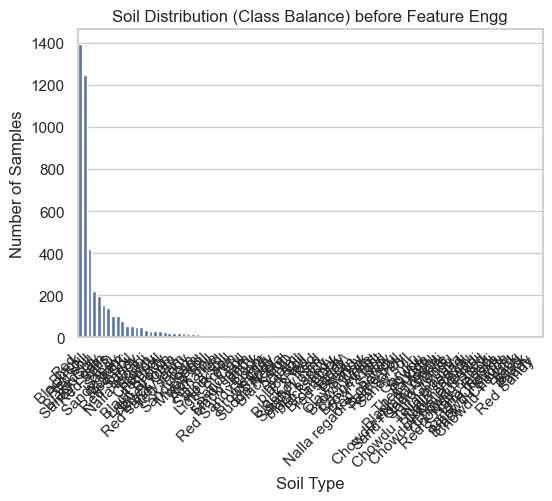

In [344]:
plt.figure(figsize=(6, 4))
soil_counts_orig = orig_df['Soil type'].value_counts()
sns.barplot(x=soil_counts_orig.index, y=soil_counts_orig.values)
plt.title('Soil Distribution (Class Balance) before Feature Engg')
plt.xlabel('Soil Type')
plt.ylabel('Number of Samples')
plt.xticks(rotation=45, ha='right')
plt.show()

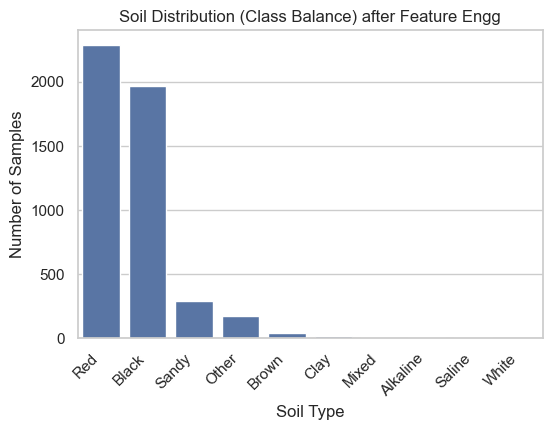

In [345]:
plt.figure(figsize=(6, 4))
soil_counts = df['Soil_Type_Standard'].value_counts()
sns.barplot(x=soil_counts.index, y=soil_counts.values)
plt.title('Soil Distribution (Class Balance) after Feature Engg')
plt.xlabel('Soil Type')
plt.ylabel('Number of Samples')
plt.xticks(rotation=45, ha='right')
plt.show()

### 3.2 EDA - Crop Distribution

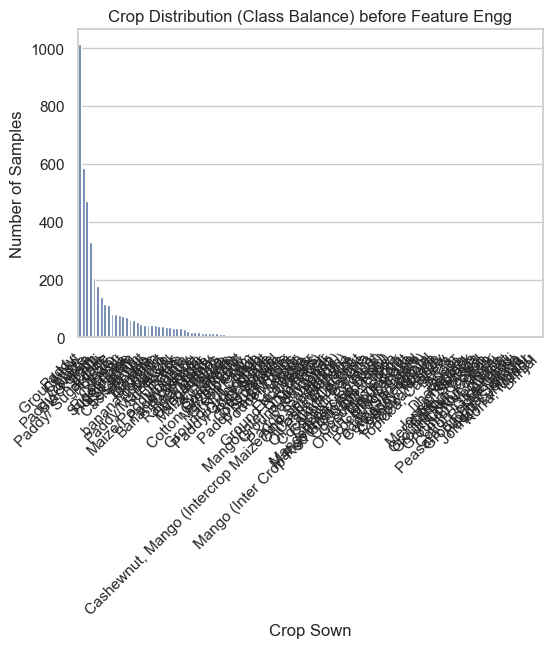

In [346]:
plt.figure(figsize=(6, 4))
soil_counts_orig = orig_df['Crop_Sown'].value_counts()
sns.barplot(x=soil_counts_orig.index, y=soil_counts_orig.values)
plt.title('Crop Distribution (Class Balance) before Feature Engg')
plt.xlabel('Crop Sown')
plt.ylabel('Number of Samples')
plt.xticks(rotation=45, ha='right')
plt.show()

In [347]:
# Extract first element from each list
# df['First_Crop'] = df['Crop_Sown_Standard'].apply(lambda x: x[0] if isinstance(x, list) and x else None)
# df_EDA = df
#df.drop(columns=["Crop_Sown_Standard"], inplace=True)

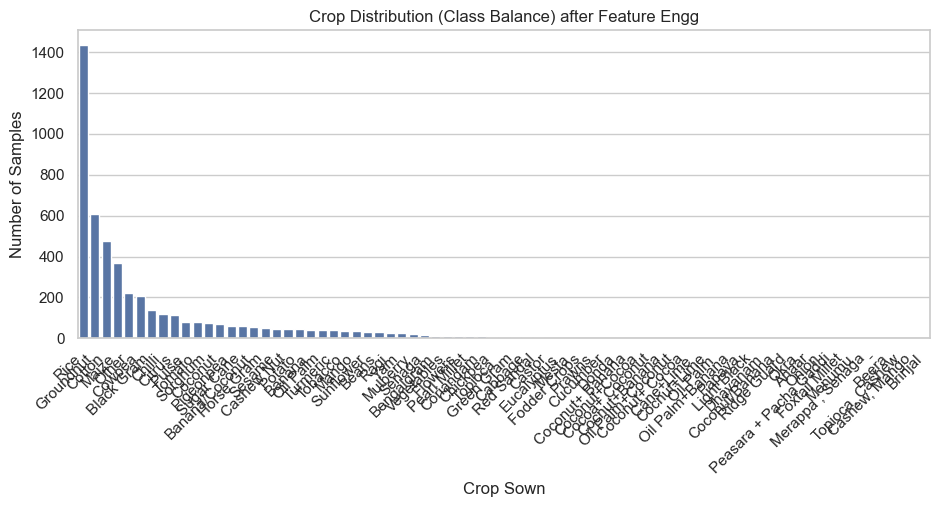

In [349]:
plt.figure(figsize=(11, 4))
crop_counts = df['Crop_Sown_Standard'].value_counts()
sns.barplot(x=crop_counts.index, y=crop_counts.values)
plt.title('Crop Distribution (Class Balance) after Feature Engg')
plt.xlabel('Crop Sown')
plt.ylabel('Number of Samples')
plt.xticks(rotation=45, ha='right')
plt.show()

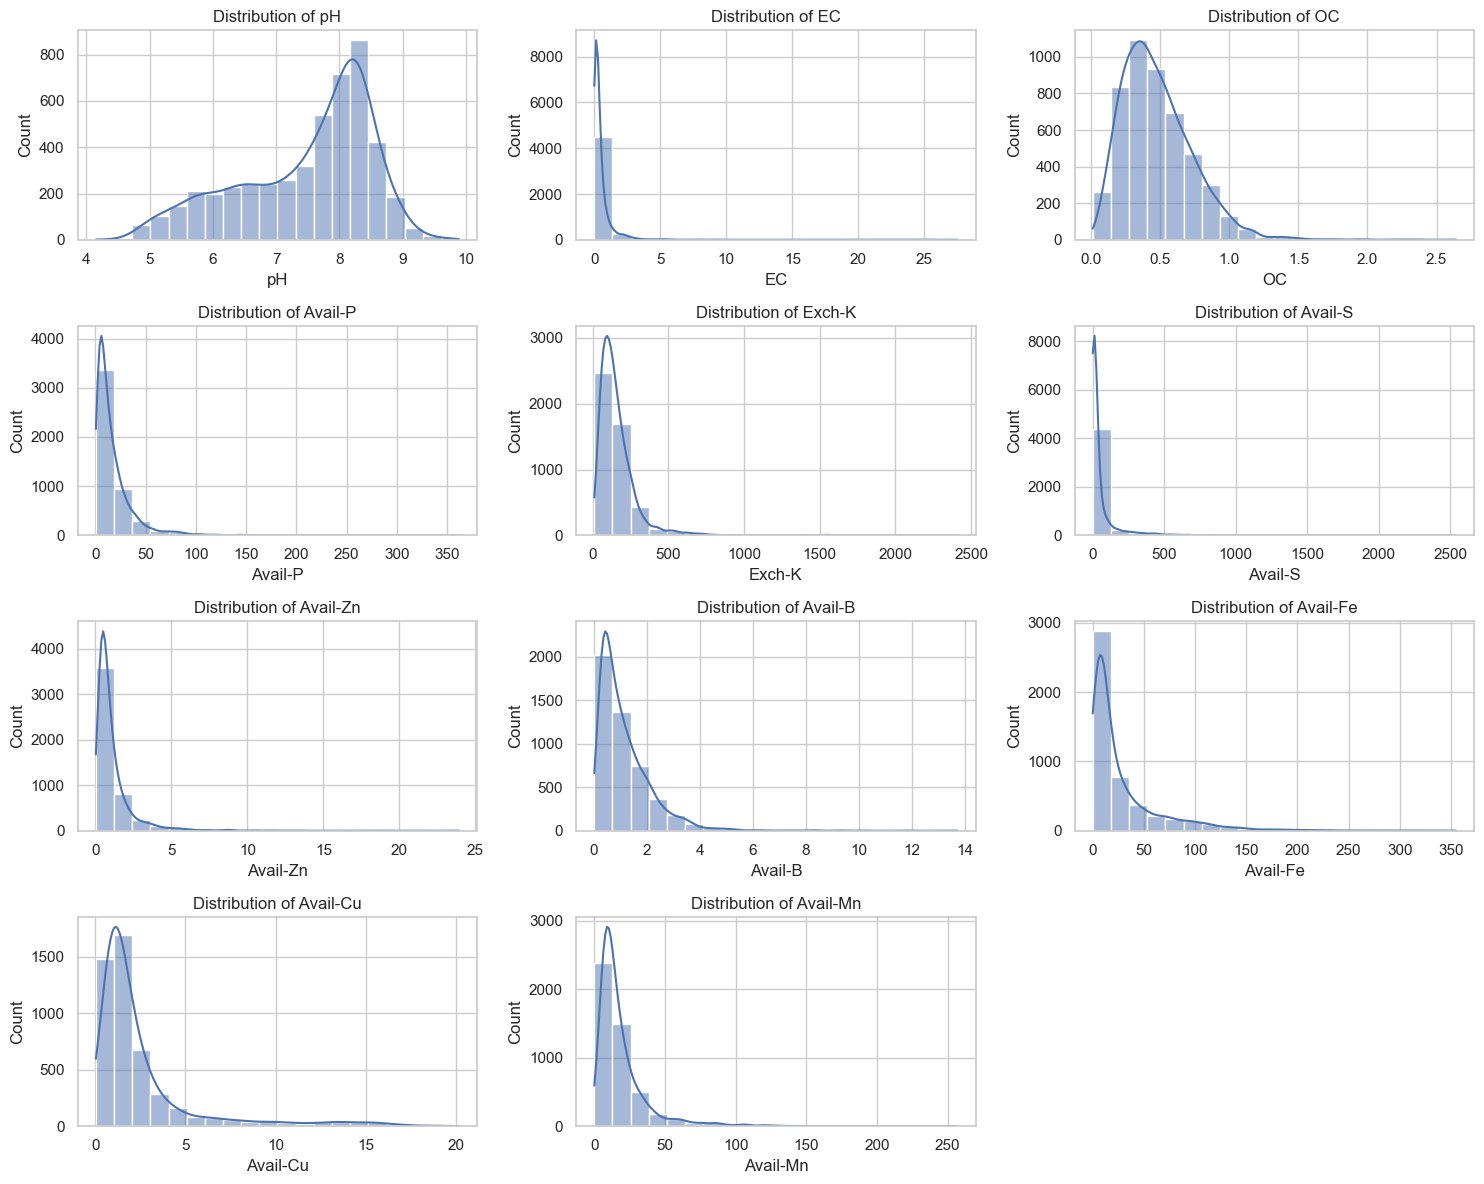

In [377]:
# Set plotting style
sns.set(style="whitegrid")

# ✔ Distribution of Nutrients
#print("\n--- EDA: Distribution of Nutrients ---")
# Update nutrient_cols to match the columns in df_processed (using hyphens)
nutrient_cols = ['pH', 'EC', 'OC', 'Avail-P', 'Exch-K', 'Avail-S', 'Avail-Zn', 'Avail-B', 'Avail-Fe', 'Avail-Cu', 'Avail-Mn']

plt.figure(figsize=(15, 12))
for i, col in enumerate(nutrient_cols):
    plt.subplot(4, 3, i + 1) # Adjust subplot layout
    sns.histplot(df[col], kde=True, bins=20) # Use df_processed instead of data
    plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.show()

In [378]:
# sns.set(style="whitegrid")
# nutrient_cols = ['pH', 'EC', 'OC', 'Avail-P', 'Exch-K', 'Avail-S', 'Avail-Zn', 'Avail-B', 'Avail-Fe', 'Avail-Cu', 'Avail-Mn']
# df[nutrient_cols].hist(bins=30, figsize =(20,20))
# plt.show()

<Axes: >

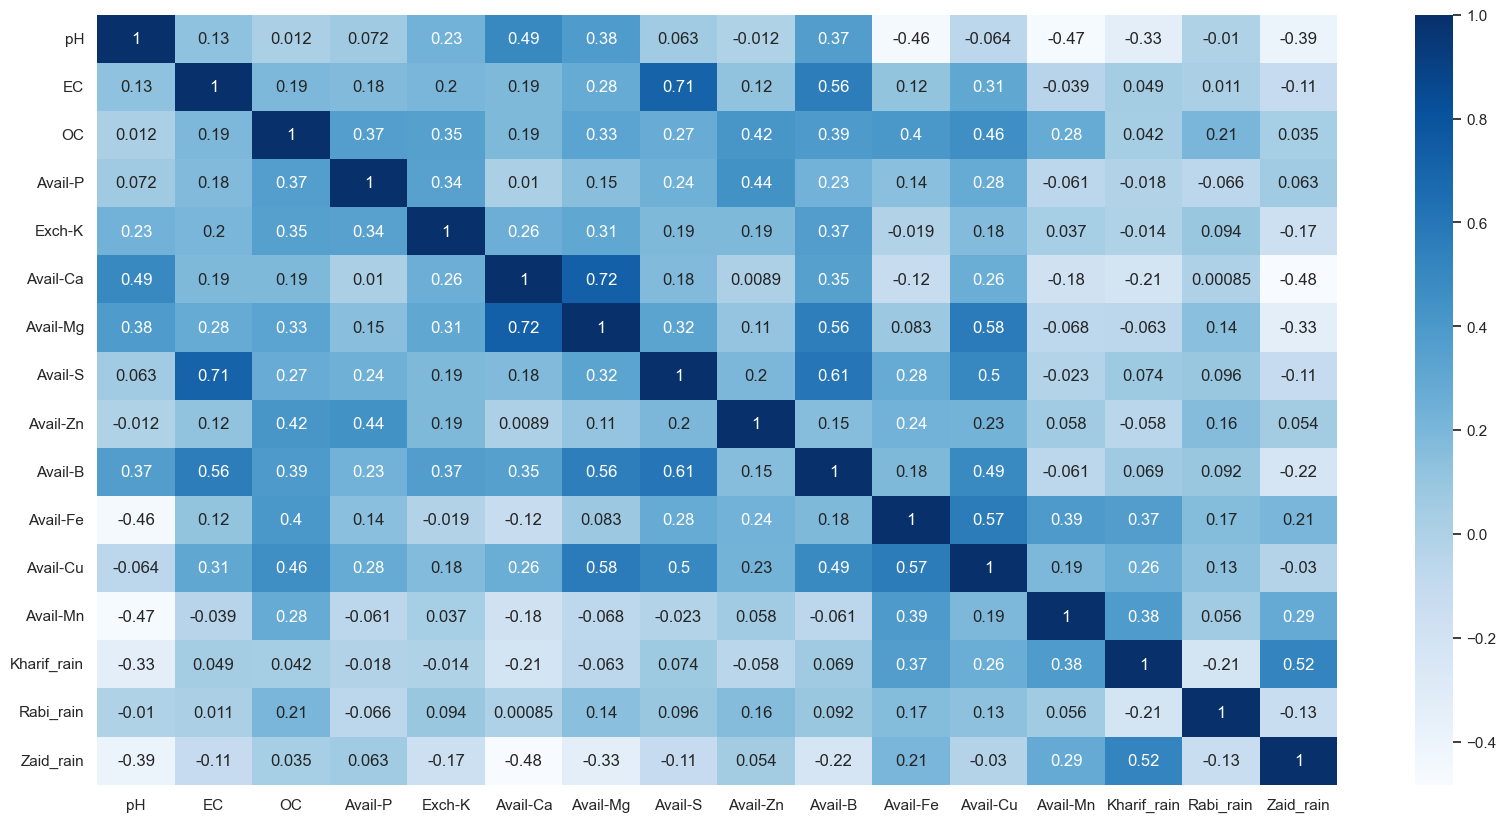

In [352]:
plt.figure(figsize=(20, 10))
sns.heatmap(df[numerical_cols].corr(), cmap="Blues",annot=True)

In [354]:
# Remove Categorical variables
# df_new = df.drop(['District', 'Mandal', 'Village', "Soil_Type_Standard" ,"First_Crop"], axis=1)

In [355]:
df_new = df

In [356]:
df_new.head()

,District,Mandal,Village,Soil type,Crop_Sown,pH,EC,OC,Avail-P,Exch-K,...,Avail-Zn,Avail-B,Avail-Fe,Avail-Cu,Avail-Mn,Kharif_rain,Rabi_rain,Zaid_rain,Soil_Type_Standard,Crop_Sown_Standard
0,Ananthapur,Penukonda,Gonipeta,Mixed soil,Ground Nut,6.19,0.07,0.18,7.13,41.0,...,0.30,0.17,8.89,0.51,15.24,272.0,148.0,77.0,Mixed,Groundnut
1,Ananthapur,Penukonda,Gonipeta,Redsoil,Ground Nut,8.40,0.33,0.31,10.34,102.0,...,0.36,0.57,3.24,0.44,6.90,272.0,148.0,77.0,Red,Groundnut
2,Ananthapur,Penukonda,Gonipeta,Mixed soil,Ground Nut,7.10,0.11,0.17,8.46,46.0,...,0.37,0.19,5.54,0.42,8.34,272.0,148.0,77.0,Mixed,Groundnut
3,Ananthapur,Penukonda,Gonipeta,Sandi soil,Horse gram,8.30,0.21,0.20,2.31,35.0,...,0.23,0.21,1.79,0.67,4.17,272.0,148.0,77.0,Sandy,Horse Gram
4,Ananthapur,Penukonda,Gonipeta,Mixed soil,Horse gram,6.40,0.06,0.22,6.08,76.0,...,0.36,0.22,22.26,0.45,9.20,272.0,148.0,77.0,Mixed,Horse Gram


In [357]:
# prob_cols = ['Soil type', 'Crop_Sown','Soil_Type_Standard','Crop_Sown_Standard']
# for col in prob_cols:
#     print(col, df[col].nunique(),df[col].unique()[0:2000],'\n')
for col in df.columns:
    print(col, df[col].nunique(),df[col].unique()[0:200000],'\n')

District 13 ['Ananthapur' 'Chittoor' 'East Godavari' 'Guntur' 'Kadapa' 'Krishna'
 'Kurnool' 'Nellore' 'Prakasam' 'Srikakulam' 'Visakhapatnam'
 'Vizianagaram' 'West Godavari' nan] 

Mandal 31 ['Penukonda' 'Raptadu' 'Santipuram' 'V.Kota' 'Gangavaram' 'Kollur'
 'Sattenapalli' 'B Mattam' 'Porumamilla' 'Sambepalli' 'Veeraballi'
 'G Konduru' 'Ghantasala' 'Banaganpalli' 'Devanakonda' 'Indukurpeta'
 'Podalakuru' 'T.P.Gudur' 'Kanigiri' 'Konakana Mitta' 'Ongole' 'Polaki'
 'Ranasthalam' 'Seethampeta' 'Butchayyapeta' 'Chintapalli' 'Padmanabham'
 'Parvathipuram' 'Pusapatirega' 'Akividu' 'Kamavarau Kota' nan] 

Village 251 ['Gonipeta' 'Kondampalli' 'Settipalli' 'G.Koythapally' 'Gandlaparthi'
 'Gollapalli' 'Palbhavi' 'Pesarakunta' 'Pullalarevu' 'Raminepally'
 '121.Pedduru' '30.Sonneganipalle' 'Bellakogilla' 'Bendamakuppam'
 'Chinnaridoddi' 'Dandikuppam' 'Kadapalle' 'Kenumakulapalle'
 'Konerukuppam' 'Settiballa' 'Sonneganipalle' 'Vadagandlapalle'
 'Bairupalli' 'Balendrapalle' 'Bellakunta' 'Govindapura

In [372]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4816 entries, 0 to 4815
Data columns (total 23 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   District            4815 non-null   object 
 1   Mandal              4815 non-null   object 
 2   Village             4815 non-null   object 
 3   Soil type           4749 non-null   object 
 4   Crop_Sown           4595 non-null   object 
 5   pH                  4816 non-null   float64
 6   EC                  4816 non-null   float64
 7   OC                  4816 non-null   float64
 8   Avail-P             4816 non-null   float64
 9   Exch-K              4816 non-null   float64
 10  Avail-Ca            4816 non-null   float64
 11  Avail-Mg            4816 non-null   float64
 12  Avail-S             4816 non-null   float64
 13  Avail-Zn            4816 non-null   float64
 14  Avail-B             4816 non-null   float64
 15  Avail-Fe            4816 non-null   float64
 16  Avail-

In [358]:
num_cols = [c for c in [
    "pH","EC","OC","Avail-P","Exch-K","Avail-Ca","Avail-Mg","Avail-S",
    "Avail-Zn","Avail-B","Avail-Fe","Avail-Cu","Avail-Mn",
    "Kharif_rain","Rabi_rain","Zaid_rain"
] if c in df.columns]
cat_cols = [c for c in ["District","Soil_Type_Standard"] if c in df.columns]
target = "Crop_Sown_Standard"

In [359]:
if USE_TOP_N_CLASSES:
    top_classes = df[target].value_counts().head(TOP_N).index
    df_new_anuj = df[df[target].isin(top_classes)].copy()

for c in cat_cols: df_new_anuj[c] = df_new_anuj[c].astype("string").fillna("Unknown")
for c in num_cols: df_new_anuj[c] = df_new_anuj[c].fillna(0).astype(float)

In [371]:
print("num_cols",num_cols)
print("cat_cols",cat_cols)

num_cols ['pH', 'EC', 'OC', 'Avail-P', 'Exch-K', 'Avail-Ca', 'Avail-Mg', 'Avail-S', 'Avail-Zn', 'Avail-B', 'Avail-Fe', 'Avail-Cu', 'Avail-Mn', 'Kharif_rain', 'Rabi_rain', 'Zaid_rain']
cat_cols ['District', 'Soil_Type_Standard']


In [360]:
df_new_anuj.shape

(3923, 23)

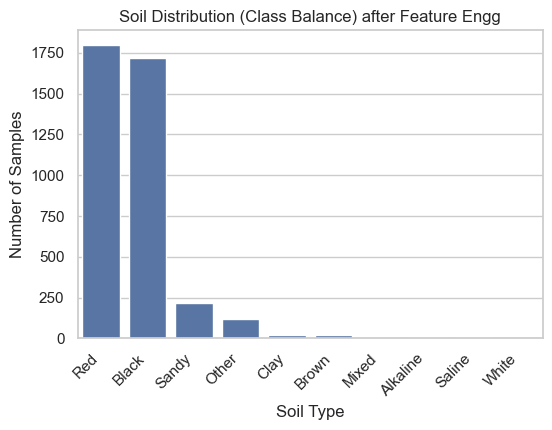

In [362]:
plt.figure(figsize=(6, 4))
soil_counts = df_new_anuj['Soil_Type_Standard'].value_counts()
sns.barplot(x=soil_counts.index, y=soil_counts.values)
plt.title('Soil Distribution (Class Balance) after Feature Engg')
plt.xlabel('Soil Type')
plt.ylabel('Number of Samples')
plt.xticks(rotation=45, ha='right')
plt.show()

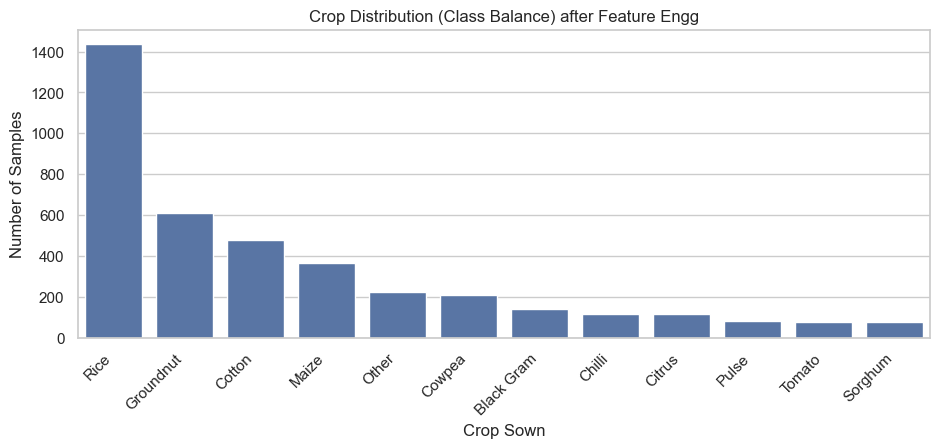

In [363]:
plt.figure(figsize=(11, 4))
crop_counts = df_new_anuj['Crop_Sown_Standard'].value_counts()
sns.barplot(x=crop_counts.index, y=crop_counts.values)
plt.title('Crop Distribution (Class Balance) after Feature Engg')
plt.xlabel('Crop Sown')
plt.ylabel('Number of Samples')
plt.xticks(rotation=45, ha='right')
plt.show()

In [353]:
# #Encode 3 categorical variables which need to be converted to numerical format
# from sklearn.preprocessing import LabelEncoder

# le = LabelEncoder()  
# df['District_encoded']=le.fit_transform(df['District'])
# df['Mandal_encoded']=le.fit_transform(df['Mandal'])
# df['Village_encoded']=le.fit_transform(df['Village'])
# df['Soil_Type_Standard_encoded']=le.fit_transform(df['Soil_Type_Standard'])
# #df['First_Crop_encoded']=le.fit_transform(df['First_Crop'])

# df['First_Crop_encoded']=le.fit(df['First_Crop'])

In [373]:
#Create numpy arrays for features and target
#X = df_new_anuj.drop('Crop_Sown_Standard',axis=1).values
X = df_new_anuj[num_cols + cat_cols].copy()
y = df_new_anuj['Crop_Sown_Standard'].values

In [375]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, stratify=y, random_state=RANDOM_STATE)
le = LabelEncoder().fit(y)
y_true_int = le.transform(y_test)

In [374]:
# ===================== CLONE-SAFE CATBOOST WRAPPER =====================
class CatBoostAutoCat(CatBoostClassifier):
    def __init__(self, cat_feature_names=None, **kwargs):
        self.cat_feature_names = cat_feature_names
        super().__init__(**kwargs)
    def get_params(self, deep=True):
        params = super().get_params(deep)
        params["cat_feature_names"] = self.cat_feature_names
        return params
    def set_params(self, **params):
        if "cat_feature_names" in params:
            self.cat_feature_names = params.pop("cat_feature_names")
        return super().set_params(**params)
    def fit(self, X, y=None, **fit_params):
        if isinstance(X, pd.DataFrame) and self.cat_feature_names:
            cf = [c for c in self.cat_feature_names if c in X.columns]
            return super().fit(X, y, cat_features=cf, **fit_params)
        return super().fit(X, y, **fit_params)

# ===================== BASE MODELS =====================
prep = ColumnTransformer([
    ("num", StandardScaler(), num_cols),
    ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), cat_cols)
])
rf  = Pipeline([("prep", prep), ("clf", RandomForestClassifier(n_estimators=500, random_state=RANDOM_STATE))])
gb  = Pipeline([("prep", prep), ("clf", GradientBoostingClassifier(random_state=RANDOM_STATE))])
knn = Pipeline([("prep", prep), ("clf", KNeighborsClassifier(n_neighbors=15, weights="distance"))])
cb  = CatBoostAutoCat(cat_feature_names=cat_cols, **CB_PARAMS)

# ===================== INDIVIDUAL MODEL EVALUATION =====================
print("🔹 Training and evaluating individual models...")

models = {
    "CatBoost": cb,
    "RandomForest": rf,
    "GradientBoosting": gb,
    "KNN": knn
}

results = []

for name, model in models.items():
    print(f"\n▶ Training {name}...")
    model.fit(X_train, y_train)

    probs = model.predict_proba(X_test)
    order = [np.where(model.classes_ == c)[0][0] for c in le.classes_]
    probs_aligned = probs[:, order]

    acc1  = top_k_accuracy_score(y_true_int, probs_aligned, k=1)
    acc3  = top_k_accuracy_score(y_true_int, probs_aligned, k=3)
    acc10 = top_k_accuracy_score(y_true_int, probs_aligned, k=min(10, probs_aligned.shape[1]))

    print(f"{name} — Top-1: {acc1:.4f} | Top-3: {acc3:.4f} | Top-10: {acc10:.4f}")
    results.append((name, acc1, acc3, acc10))

# ===================== SOFT VOTING ENSEMBLE =====================
print("\n🔹 Training Soft VotingClassifier (CatBoost + RF + GB + KNN)…")

voter = VotingClassifier(
    estimators=[
        ("CatBoost", cb),
        ("RandomForest", rf),
        ("GradientBoosting", gb),
        ("KNN", knn)
    ],
    voting="soft"
)
voter.fit(X_train, y_train)

# ===================== EVALUATION =====================
probs_vote = voter.predict_proba(X_test)
order = [np.where(voter.classes_ == c)[0][0] for c in le.classes_]
probs_aligned = probs_vote[:, order]

acc_top1  = top_k_accuracy_score(y_true_int, probs_aligned, k=1)
acc_top3  = top_k_accuracy_score(y_true_int, probs_aligned, k=3)
acc_top10 = top_k_accuracy_score(y_true_int, probs_aligned, k=min(10, probs_aligned.shape[1]))

print(f"\n✅ SoftVoting — Top-1: {acc_top1:.4f} | Top-3: {acc_top3:.4f} | Top-10: {acc_top10:.4f}")

# Save results to CSV for easy comparison
compare_df = pd.DataFrame(results, columns=["Model", "Top-1", "Top-3", "Top-10"])
compare_df.loc[len(compare_df)] = ["SoftVoting", acc_top1, acc_top3, acc_top10]
compare_df.to_csv(COMPARE_CSV, index=False)

print(f"\n💾 Accuracy comparison saved to {COMPARE_CSV}")




joblib.dump({
    "model": voter,
    "feature_names": X.columns.tolist(),
    "cat_cols": cat_cols,
    "num_cols": num_cols,
    "label_encoder": le
}, MODEL_OUT_VOTE)
print("💾 Saved model:", MODEL_OUT_VOTE)

🔹 Training and evaluating individual models...

▶ Training CatBoost...
CatBoost — Top-1: 0.7554 | Top-3: 0.9725 | Top-10: 0.9990

▶ Training RandomForest...
RandomForest — Top-1: 0.7625 | Top-3: 0.9684 | Top-10: 0.9980

▶ Training GradientBoosting...
GradientBoosting — Top-1: 0.7431 | Top-3: 0.9531 | Top-10: 1.0000

▶ Training KNN...
KNN — Top-1: 0.7350 | Top-3: 0.9572 | Top-10: 0.9929

🔹 Training Soft VotingClassifier (CatBoost + RF + GB + KNN)…

✅ SoftVoting — Top-1: 0.7543 | Top-3: 0.9704 | Top-10: 1.0000

💾 Accuracy comparison saved to model_comparison_top3_voting.csv
💾 Saved model: soft_voting_model.pkl
